In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import optimize
%matplotlib inline

In [2]:
n_sec = 20
sec_names = list("s" + str(i+1) for i in range(n_sec))

In [3]:
np.random.seed(100500)
N = 2000
data = np.random.normal(loc = 0.0, scale = 3.8, size = (n_sec, N))

df_ret = pd.DataFrame(np.array([data[i].cumsum() + 1000 for i in range(len(data))]).transpose(), columns = sec_names)
df_ret = df_ret[200:].copy()
df_ret.index = np.arange(len(df_ret))
df_ret.head()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20
0,980.236153,1027.692248,902.951382,970.854519,990.607535,1067.828083,1030.996685,1015.559619,1030.287274,1101.512912,1056.694751,1039.250344,1059.246466,1014.636029,1053.524518,981.531752,1005.353997,1020.634777,1054.519081,871.833840
1,990.175220,1031.636346,904.123510,962.159695,989.029455,1068.285421,1029.695857,1016.548048,1026.986878,1101.087449,1053.893920,1039.636954,1057.900954,1020.389620,1058.119460,977.508782,997.844627,1017.632017,1056.919540,876.287784
2,998.786116,1031.779016,901.452289,967.232517,987.412261,1069.784623,1033.562437,1009.315460,1028.661264,1102.784169,1054.522990,1040.096309,1056.524775,1019.106727,1054.560576,983.088831,999.937439,1014.576151,1053.621138,874.775403
3,1000.788456,1033.222976,896.908107,968.317376,986.840660,1069.900203,1030.965980,1009.270157,1028.460731,1104.870595,1051.659364,1041.808612,1058.120159,1016.688068,1058.438576,984.443184,1001.816272,1005.273188,1055.654836,879.005012
4,996.898229,1035.800530,899.754893,964.653526,984.559279,1065.205718,1033.368605,1008.019166,1029.072704,1103.785334,1058.859294,1038.502200,1056.115471,1017.202223,1066.499003,986.054000,1004.601140,1004.448038,1055.010768,876.948658


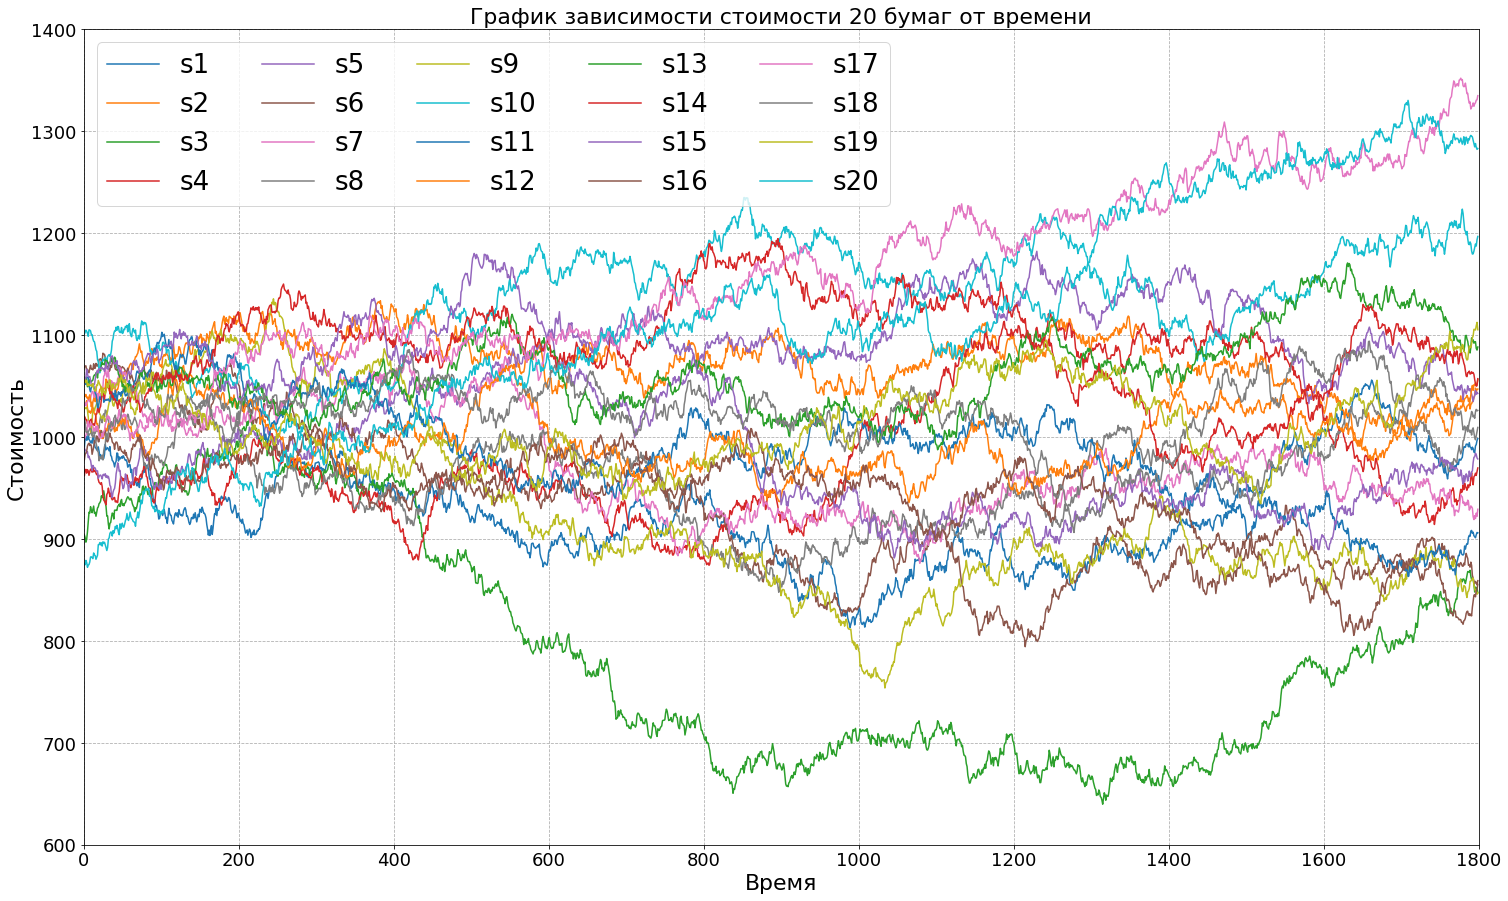

In [6]:
df_ret.plot(figsize = (25, 15))
plt.grid (True, linestyle = '--')
plt.legend (labelspacing = 0.5, ncol = 5, fontsize = 26)
plt.axis([0,1800,600,1400])
plt.xlabel('Время', size = 22)
plt.ylabel('Стоимость', size = 22)
plt.tick_params(labelsize = 18)
plt.title('График зависимости стоимости {} бумаг от времени'.format(n_sec), size = 22)
plt.show()

In [7]:
target_r = 0.16

In [8]:
time_periods = 1800

def ret_std (weights, mean_returns, cov_matrix):
    ret = np.dot(mean_returns, weights) * time_periods
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(time_periods)
    return std, ret

def neg_sharpe_ratio(weights, mean_returns, cov_matrix):
    risk, ret = ret_std(weights, mean_returns, cov_matrix)
    return -(ret) / risk

def risk(weights, mean_returns, cov_matrix):
    return ret_std(weights, mean_returns, cov_matrix)[0]

def efficient_return(mean_returns, cov_matrix, target):
    def ret(weights):
        return ret_std(weights, mean_returns, cov_matrix)[1]
    cons = ({'type': 'eq', 'fun': lambda x: ret(x) - target}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.0,1.0) for i in range(len(mean_returns)))
    result = optimize.minimize(risk, len(mean_returns) * [1./len(mean_returns),], args = (mean_returns, cov_matrix),
                          method = 'SLSQP', bounds = bounds, constraints = cons)
    return result

def max_sharpe_ratio(mean_returns, cov_matrix):
    args = (mean_returns, cov_matrix)
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.0,1.0) for i in range(len(mean_returns))) 
    result = optimize.minimize(neg_sharpe_ratio, len(mean_returns) * [1. / len(mean_returns),],
                               args = (mean_returns, cov_matrix), method = 'SLSQP', bounds = bounds, 
                               constraints = cons)
    return result

def min_risk(mean_returns, cov_matrix):
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.0,1.0) for i in range(len(mean_returns)))
    result = optimize.minimize(risk, len(mean_returns) * [1. / len(mean_returns),],
                               args = (mean_returns, cov_matrix), method = 'SLSQP', bounds = bounds,
                               constraints = cons)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    pfs = []
    for ret in returns_range:
        pfs.append(efficient_return(mean_returns, cov_matrix, ret))
    return pfs

In [10]:
mz = efficient_return(mean_returns, cov_matrix, target_r)
risk_target, return_target = ret_std(mz.x, mean_returns, cov_matrix)

In [9]:
periodical_returns = df_ret.pct_change()
mean_returns = periodical_returns.mean()
cov_matrix = periodical_returns.cov()

min_volatility = min_risk(mean_returns, cov_matrix)
min_possible_risk, return_min_possible_risk = ret_std(min_volatility.x, mean_returns, cov_matrix)

max_sharpe_coef = max_sharpe_ratio(mean_returns, cov_matrix)
risk_max_sharpe, return_max_sharpe = ret_std(max_sharpe_coef.x, mean_returns, cov_matrix)

returns = np.linspace(return_min_possible_risk, return_max_sharpe, 20)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, returns)

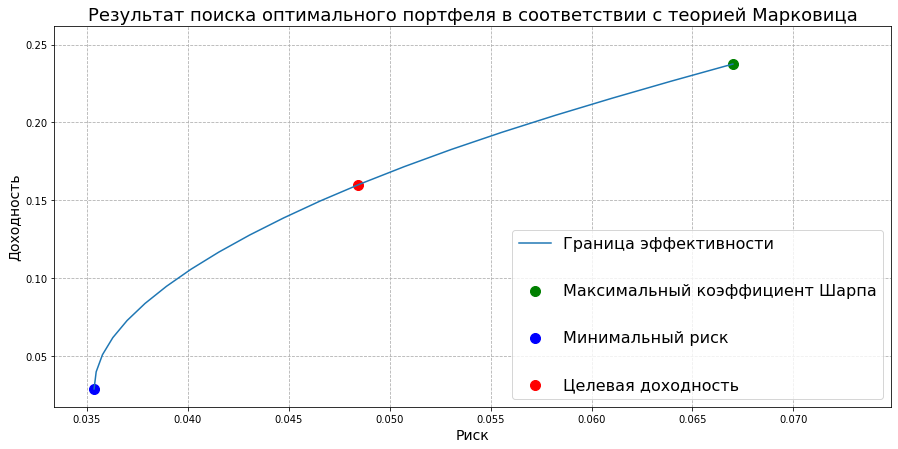

In [12]:
plt.figure(figsize = (15, 7))

plt.scatter(risk_max_sharpe, return_max_sharpe, color = 'Green', s = 100, label = 'Максимальный коэффициент Шарпа')
plt.scatter(min_possible_risk, return_min_possible_risk, color = 'Blue', s = 100, label = 'Минимальный риск')
plt.scatter(risk_target, return_target, color = 'Red', s = 100, label = 'Целевая доходность')

plt.plot([p['fun'] for p in efficient_portfolios], returns, label = 'Граница эффективности')
plt.title('Результат поиска оптимального портфеля в соответствии с теорией Марковица', size = 18)
plt.xlabel('Риск',size=14)
plt.ylabel('Доходность',size=14)
plt.grid(True, linestyle = '--')
plt.legend(labelspacing = 2, fontsize=16)
plt.show()

In [13]:
n_stat = np.random.randint(1, n_sec)
print ("Number of given statements: ", n_stat)

statements = []
for i in range(n_stat):
    t = np.random.choice(np.arange(0, n_sec), replace = False, size = 2)
    statements.append(tuple((max(t), min(t))))

Number of given statements:  9


In [14]:
M_eq = np.ones(shape = (2, n_sec + 1))
M_eq[0, :n_sec] = mean_returns
M_eq[:, n_sec] = 0.0

M_ieq = np.zeros(shape = (n_stat, n_sec + 1), dtype = int)
for i in range(0, len(statements)):  
    M_ieq[i, statements[i][0]] -= 1 
    M_ieq[i, statements[i][1]] += 1
M_ieq[:, n_sec] += 1

bounds_ineq = [tuple((0,1))] * n_sec
bounds_ineq.append((None, None))

M_z = np.zeros(n_sec + 1)
M_z[n_sec] = -1.

In [15]:
results_soft_ineq = optimize.linprog(M_z,
    A_ub = M_ieq, b_ub = np.zeros(n_stat),
    A_eq = M_eq, b_eq = [target_r / time_periods , 1], 
    bounds = bounds_ineq)

results_soft_ineq.success

True

In [16]:
soft_ineq_risk, soft_ineq_return = ret_std(results_soft_ineq.x[:n_sec], mean_returns, cov_matrix)

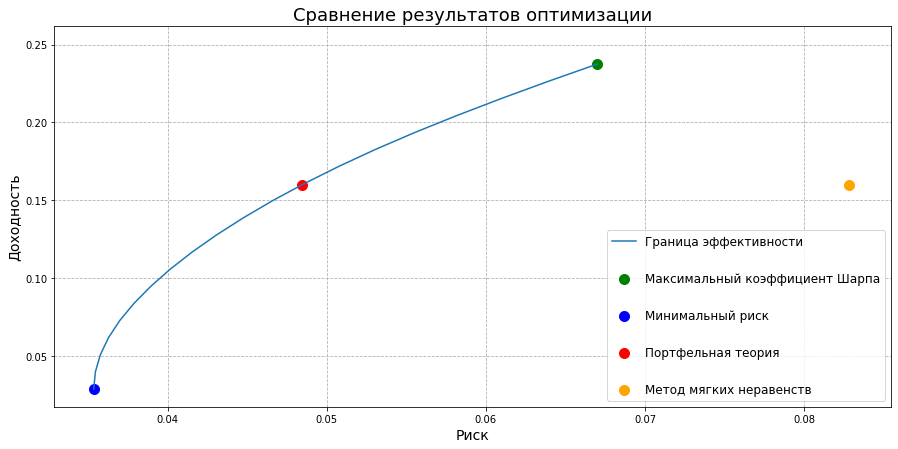

In [17]:
plt.figure(figsize=(15, 7))

plt.scatter(risk_max_sharpe, return_max_sharpe, color = 'Green', s = 100, label = 'Максимальный коэффициент Шарпа')
plt.scatter(min_possible_risk, return_min_possible_risk, color = 'Blue', s = 100, label = 'Минимальный риск')
plt.scatter(risk_target, return_target, color = 'Red', s = 100, label = 'Портфельная теория')
plt.scatter(soft_ineq_risk, soft_ineq_return, color = 'Orange', s = 100, label = 'Метод мягких неравенств')

plt.plot([p['fun'] for p in efficient_portfolios], returns, label = 'Граница эффективности')
plt.title('Сравнение результатов оптимизации',size=18)
plt.xlabel('Риск',size=14)
plt.ylabel('Доходность',size=14)
plt.grid(True, linestyle = '--')
plt.legend(labelspacing = 2, fontsize=12)